In [1]:
%matplotlib inline
%config InlineBackend.figure_format = True
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar
import caos 

from caos import Star, Spot

spot_table = ascii.read('/Users/bmmorris/data/Mt_Wilson_Tilt/mwo_spot_table.txt').group_by('jd')
spot_table.add_index('jd')

Example, demo of API:

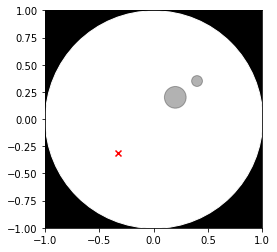

In [2]:
s = Star()

spot_list = [Spot(x=0.2, y=0.20, r=0.10),
             Spot(x=0.4, y=0.35, r=0.05)]

s.spots.extend(spot_list)

ax = s.plot(col_exaggerate=50)

For all dates in the MWO spot catalog, compute the solar photocenter. 

In [3]:
dates = sorted(list(set(spot_table['jd'])))
center_of_light = []

scale_up_umbra = 5

with ProgressBar(len(dates), ipython_widget=True) as bar:
    for date in dates:    
        sun = Star()
        spots_today = spot_table[spot_table['jd'] == date]

        for spot in spots_today:
            lon = spot['area_weighted_longitude_day_1']
            lat = spot['area_weighted_latitude_day_1']
            areas = spot['area_day_1']
            rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
            new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
            sun.spots.append(new_spot)

        center_of_light.append(sun.center_of_light)
        bar.update()

center_of_light = np.array(center_of_light)
#     sun.plot()
#     plt.show()

In [4]:
#plt.scatter(center_of_light[:, 0], center_of_light[:, 1], marker='.', s=2, c=dates)

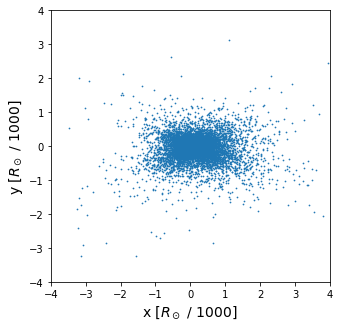

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(center_of_light[:, 0] * 1000, center_of_light[:, 1] * 1000, marker='.', s=2)
ax.set_xlabel('x [$R_\odot$ / 1000]', fontsize=14)
ax.set_ylabel('y [$R_\odot$ / 1000]', fontsize=14)
ax.set(xlim=[-4, 4], ylim=[-4, 4])
fig.savefig('plots/photocenter_motion.pdf', bbox_inches='tight')

What is the meadian absolute deviation of the solar photocenter over the entire MWO sample?

In [6]:
from astropy.stats import mad_std

mad = lambda x: mad_std(x)/1.4826

mad_x = mad(center_of_light[:, 0])
mad_y = mad(center_of_light[:, 1])

print("MAD x = {0}\nMAD y = {1}".format(mad_x, mad_y))

MAD x = 0.00022130824778557938
MAD y = 0.00012676118410517447


What was the maximum number of spots on the sun on a single day?

max spots 14


(array([ 4801.,  1806.,  1328.,  1773.,   445.,   300.,   273.,    61.,
           21.,    10.]),
 array([  1. ,   2.3,   3.6,   4.9,   6.2,   7.5,   8.8,  10.1,  11.4,
         12.7,  14. ]),
 <a list of 10 Patch objects>)

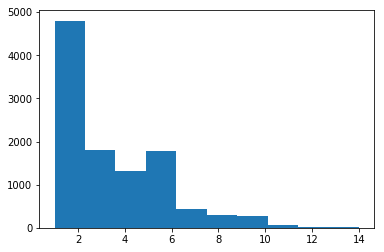

In [7]:
nspots = np.array([len(spot_table[spot_table['jd'] == date]) for date in dates])
print('max spots', np.max(nspots))
plt.hist(nspots)

Compute the sizes 

In [8]:
spot_radii = np.sqrt(1e-6 * 10 * spot_table['area_day_1'])

Compute some basic stats on spot radii, number of spots on a typical day: 

In [9]:
np.median(spot_radii), np.mean(nspots), np.median(nspots)

(0.010831897340724754, 3.3606026992050286, 3.0)

Compute the displacement vector of the solar photocenter from the true solar centroid at each time.

(0.0, 0.005)

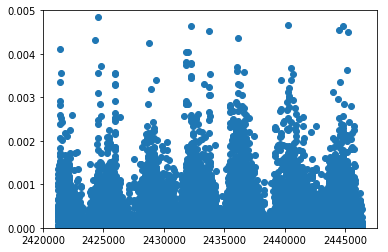

In [10]:
r_vector = np.sqrt(center_of_light[:, 0]**2 + center_of_light[:, 1]**2)
plt.scatter(dates, r_vector)
plt.ylim([0.0, 0.005])

1917-02-09 06:59:00.000


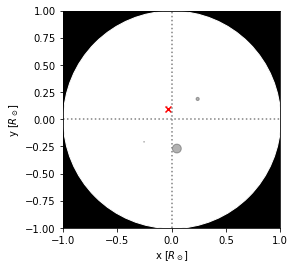

In [11]:
from astropy.time import Time

date = dates[20]

s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=100)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
fig.savefig('plots/example_sun.pdf', bbox_inches='tight')

1959-05-10 09:48:00.000


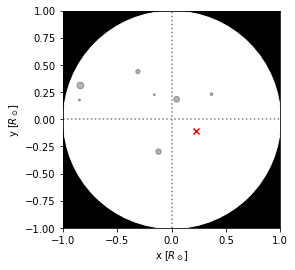

In [12]:
#date = dates[-6000]
date = dates[-4110]

fig, ax = plt.subplots()
s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=100, ax=ax)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
fig.savefig('plots/example_sun.pdf', bbox_inches='tight')

In [13]:
from astropy.constants import R_sun, M_sun, R_jup, M_jup, R_earth, M_earth, G
import astropy.units as u

a_jup = 5.2 * u.AU
a_earth = 1.0 * u.AU
p_jup = 11.8 * u.year
p_earth = 1 * u.year

# Solve for reflex motion radius

reflex_jup = ((a_jup * M_jup / M_sun)).decompose() / R_sun
reflex_earth = ((a_earth * M_earth / M_sun)).decompose() / R_sun

print(reflex_jup, reflex_earth)

1.0673959707897154 0.0006458467892169156


In [14]:
distance = 1 * u.pc
np.arctan(((reflex_jup*R_sun)/distance).decompose()).to(u.uarcsec)

<Quantity 4963.890016679382 uarcsec>

2.45813601141 uas
earth 3.0034893488743255
0.491627202281 uas
earth 0.6006978697748651
0.245813601141 uas
earth 0.30034893488743253


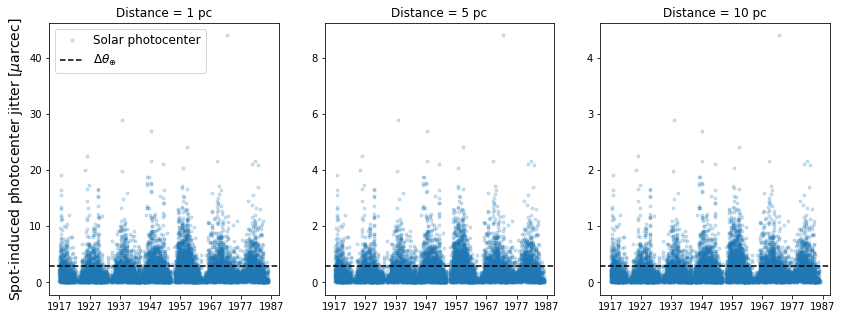

In [15]:
# Position jitter at D parsecs

from astropy.constants import R_sun
import astropy.units as u

distances = np.array([1, 5, 10])*u.pc
dates_plot = Time(dates, format='jd').plot_date

fig, ax = plt.subplots(1, len(distances), figsize=(14, 5))
for i, distance in enumerate(distances):
    angle = np.arctan(((r_vector*R_sun)/distance).decompose())

    print(np.std(angle.to(u.uarcsec).value), 'uas')
    
    earth_angle = np.arctan(((reflex_earth*R_sun)/distance).decompose())
    print('earth', earth_angle.to(u.uarcsec).value)
    ax[i].plot_date(dates_plot, angle.to(u.uarcsec), '.', alpha=0.2, 
                    label='Solar photocenter')
    ax[i].set_title('Distance = {0:d} pc'.format(int(distance.value)))
    ax[i].axhline(+earth_angle.to(u.uarcsec).value, ls='--', color='k', 
                  label=r"$\Delta \theta_{\oplus}$")

ax[0].legend(fontsize=12)
ax[0].set_ylabel('Spot-induced photocenter jitter [$\mu$arcec]', fontsize=14)
fig.savefig('plots/jitter.pdf', bbox_inches='tight', dpi=150)

On what day was the sunspot distribution most asymmetric? Plot a diagram of the sun on that day below. 

In [16]:
Time(dates[np.argmax(r_vector)], format='jd').iso

'1972-06-07 14:44:00.000'

0.000310520740615 0.00945570823652
1972-06-07 14:44:00.000


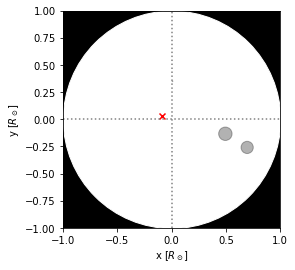

In [17]:
print(np.median(r_vector), np.max(r_vector))

date = dates[np.argmax(r_vector)]
fig, ax = plt.subplots()
s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=10, ax=ax)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
fig.savefig('plots/example_sun.pdf', bbox_inches='tight')

*** 

## Gaia noise model

Simple Gaia noise model of Perryman et al. 2014:

$$ \sigma_{fov} = \sqrt{ \sigma_\eta^2/9 + \sigma_{att}^2 + \sigma_{cal}^2} $$

where $\sigma_{att} \approx \sigma_{cal} = 20 \mu$as, and

$$ \sigma_\eta = \sqrt{53000 z + 310 z^2} $$

for 

$$ z = 10^{0.4\left(\max[G, 12] - 15\right)}$$

Which stars have astrometric errors in DR1 smaller than the estimated jitter due to solar-like activity cycles?

In [18]:
from caos import get_table_ms

/Users/bmmorris/git/caos/caos/catalog.py:57: RuntimeWarning: invalid value encountered in log10
  M_V = Vmag - 5*(np.log10(dist_pc) + 1)


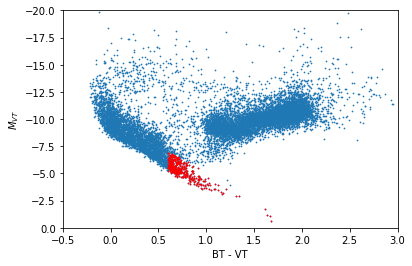

In [19]:
table, ms = get_table_ms()

(array([   0.,    0.,    0.,    0.,    0.,  383.,    0.,    0.,    0.,    0.]),
 array([ 33.73011679,  33.83011679,  33.93011679,  34.03011679,
         34.13011679,  34.23011679,  34.33011679,  34.43011679,
         34.53011679,  34.63011679,  34.73011679]),
 <a list of 10 Patch objects>)

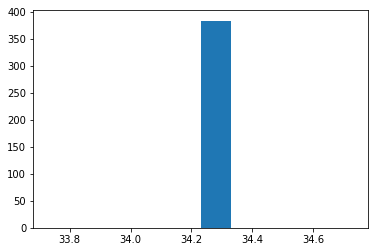

In [20]:
sigma_fovs = sigma_fov(table[ms]['<Gmag>'])

plt.hist(sigma_fovs.value)

In [21]:
#for i, distance in enumerate(distances):
#    angle = np.arctan(((r_vector*R_sun)/distance).decompose())

    
    
#     print(np.std(angle.to(u.uarcsec).value), 'uas')
    
#     earth_angle = np.arctan(((reflex_earth*R_sun)/distance).decompose())
#     print('earth', earth_angle.to(u.uarcsec).value)
#     ax[i].plot_date(dates_plot, angle.to(u.uarcsec), '.', alpha=0.2, 
#                     label='Solar photocenter')
#     ax[i].set_title('Distance = {0:d} pc'.format(int(distance.value)))
#     ax[i].axhline(+earth_angle.to(u.uarcsec).value, ls='--', color='k', 
#                   label=r"$\Delta \theta_{\oplus}$")

# Compute the apparent angular jitter due to sunspots at the
# distances of nearby MS stars in the TGAS sample
distances = table['distance'][ms]
jitter_rsun = np.std(r_vector)*R_sun
jitter_amplitude = np.arctan((jitter_rsun/distances).decompose()).to(u.uarcsec)

# Estimate the single-measurement astrometric error for each star
# in the TGAS sample: 
#astrometric_uncertainty = sigma_fov(table['<Gmag>'][ms])
astrometric_uncertainty = table['sigma_fov'][ms]/np.sqrt(table['N_fov'][ms])

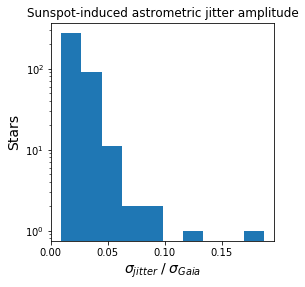

In [28]:
#plt.hist(jitter_amplitude, log=True);
plt.figure(figsize=(4, 4))
plt.hist(jitter_amplitude/astrometric_uncertainty, log=True)
plt.title('Sunspot-induced astrometric jitter amplitude')
plt.xlabel('$\sigma_{jitter} \; / \; \sigma_{Gaia}$', fontsize=14)
plt.ylabel('Stars', fontsize=14)
plt.savefig('plots/sunspot_jitter.pdf', bbox_inches='tight')

In [31]:
sorted(jitter_amplitude/astrometric_uncertainty)[-2:]

[<Quantity 0.11830075684857239>, <Quantity 0.18690269297276335>]